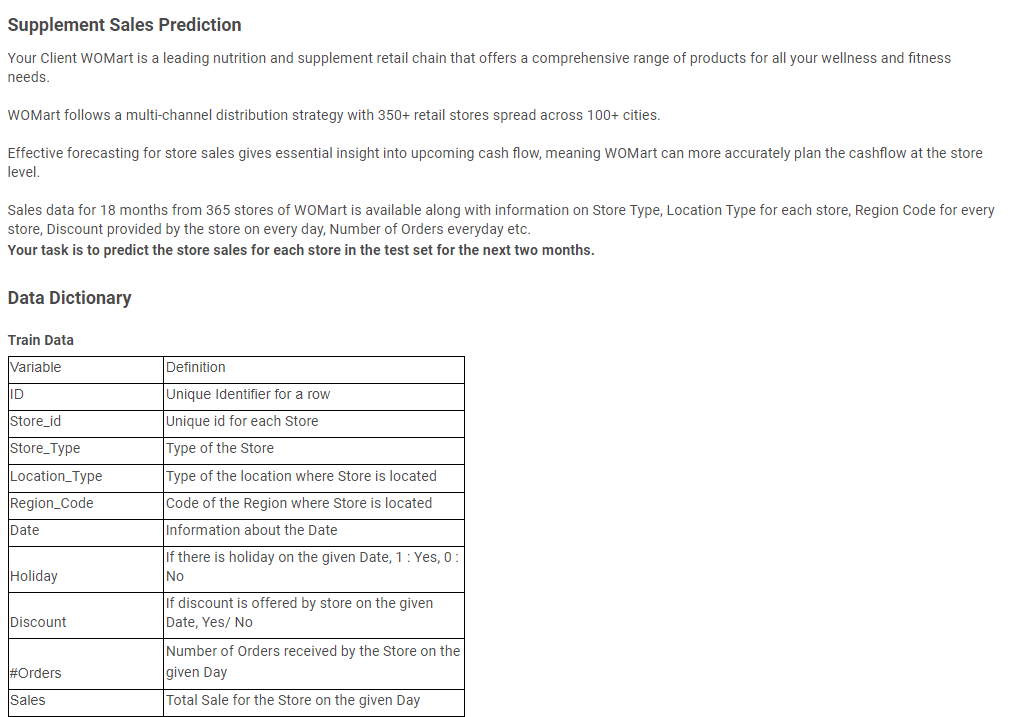

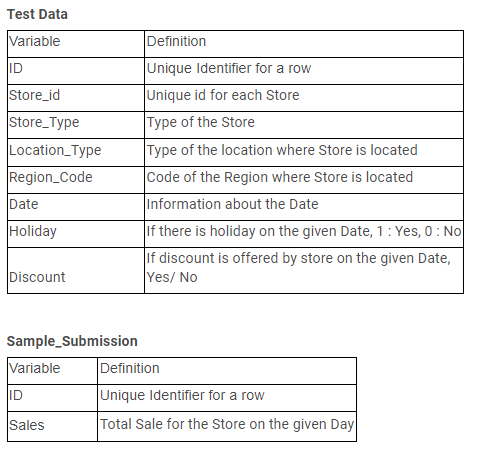

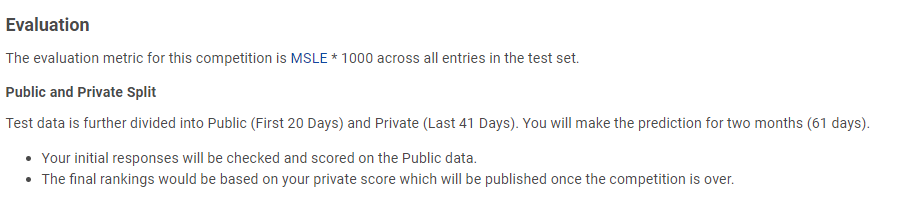

#Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import preprocessing

# Esemble of models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# from catboost import Pool, CatBoostRegressor

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
                                     Activation, 
                                     Flatten,
                                     Dense, 
                                     Dropout, 
                                     Conv1D, 
                                     Conv2D, 
                                     MaxPooling2D, 
                                     BatchNormalization,
                                     AveragePooling2D,
                                     AveragePooling1D
                                    )
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping


from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import (Input, Dense, Lambda, Reshape, Conv1D, Conv2D,
                         AveragePooling2D,Flatten, Dropout, SimpleRNN, LSTM, 
                         concatenate, Layer
                         )
from keras import backend as K
from tensorflow.keras import layers

# Load Data sets

In [2]:
path_dir = "/content/drive/MyDrive/Projects/JOB-A-THON-SEP21/"

train  = pd.read_csv(path_dir + "train.csv")
test = pd.read_csv(path_dir + "test.csv")
sample_data = pd.read_csv(path_dir + "sample_submission.csv")

In [4]:
train.head()

ID  Store_id Store_Type  ... Discount #Order     Sales
0  T1000001         1         S1  ...      Yes      9   7011.84
1  T1000002       253         S4  ...      Yes     60  51789.12
2  T1000003       252         S3  ...      Yes     42  36868.20
3  T1000004       251         S2  ...      Yes     23  19715.16
4  T1000005       250         S2  ...      Yes     62  45614.52

[5 rows x 10 columns]

In [5]:
test.head()

ID  Store_id Store_Type  ...        Date Holiday Discount
0  T1188341       171         S4  ...  2019-06-01       0       No
1  T1188342       172         S1  ...  2019-06-01       0       No
2  T1188343       173         S4  ...  2019-06-01       0       No
3  T1188344       174         S1  ...  2019-06-01       0       No
4  T1188345       170         S1  ...  2019-06-01       0       No

[5 rows x 8 columns]

In [6]:
sample_data.head()

ID  Sales
0  T1188341  42275
1  T1188342  42275
2  T1188343  42275
3  T1188344  42275
4  T1188345  42275

# Data Cleaning

In [7]:
print(test.isnull().sum())
print()
train.isnull().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
dtype: int64



ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

* No Null in Train/Test

In [8]:
print(test.info())
print()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             22265 non-null  object
 1   Store_id       22265 non-null  int64 
 2   Store_Type     22265 non-null  object
 3   Location_Type  22265 non-null  object
 4   Region_Code    22265 non-null  object
 5   Date           22265 non-null  object
 6   Holiday        22265 non-null  int64 
 7   Discount       22265 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.4+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    18834

* Sales, Order are missed in Test 

In [17]:
target = ["Sales"]
X_variable = [i for i in train.columns if i not in target and i != "#Order" and i != "Date"]

In [18]:
X_variable

['ID',
 'Store_id',
 'Store_Type',
 'Location_Type',
 'Region_Code',
 'Holiday',
 'Discount']

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_features = []
numerical_features = []

for i in X_variable:
    if train[i].dtype in numerics:
        numerical_features.append(i)
    else:
        categorical_features.append(i)
        
print(f'Numeric features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

Numeric features: ['Store_id', 'Holiday']
Categorical features: ['ID', 'Store_Type', 'Location_Type', 'Region_Code', 'Discount']


In [14]:
def label_enc(train_df, test_df, features):
    lbl_enc = preprocessing.LabelEncoder()
    full_data = pd.concat(
        [train_df[features], test_df[features]],
        axis=0
    )
    
    for col in (features):
        print(col)
        if train_df[col].dtype == 'object':
            lbl_enc.fit(full_data[col].values)
            train_df[col] = lbl_enc.transform(train_df[col])
            test_df[col] = lbl_enc.transform(test_df[col])
            
    return train_df, test_df

train_df, test_df = label_enc(train, test, categorical_features)

ID
Store_Type
Location_Type
Region_Code
Discount


In [15]:
train_df.head()

ID  Store_id  Store_Type  Location_Type  ...  Holiday Discount  #Order     Sales
0   0         1           0              2  ...        1        1       9   7011.84
1   1       253           3              1  ...        1        1      60  51789.12
2   2       252           2              1  ...        1        1      42  36868.20
3   3       251           1              2  ...        1        1      23  19715.16
4   4       250           1              2  ...        1        1      62  45614.52

[5 rows x 10 columns]

In [16]:
train.head()

ID  Store_id  Store_Type  Location_Type  ...  Holiday Discount  #Order     Sales
0   0         1           0              2  ...        1        1       9   7011.84
1   1       253           3              1  ...        1        1      60  51789.12
2   2       252           2              1  ...        1        1      42  36868.20
3   3       251           1              2  ...        1        1      23  19715.16
4   4       250           1              2  ...        1        1      62  45614.52

[5 rows x 10 columns]

# Feature Selection 

In [19]:
y = train_df[target]
X = train_df[X_variable]
x_test = test_df[X_variable]

# Models

## LGBM, XGB

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

In [23]:
Model_LGBM = LGBMRegressor()

Model_LGBM.fit(
            X_train, 
            y_train
            )

y_pred = Model_LGBM.predict(X_val)
i = 1
print(f'{i} : {metrics.mean_absolute_error(y_val, y_pred)}')
print(f'{i} : {metrics.mean_squared_error(y_val, y_pred)}')

1 : 6602.9930535194735
1 : 85663184.76035754


In [30]:
Model_XGB = XGBRegressor(
                    max_depth=12,
                    n_estimators=50,
                    min_child_weight=7, 
                    colsample_bytree=0.8,
                    learning_rate = 0.1,
                    subsample=0.8, 
                    eta=0.1,
                    seed=42
                    )

Model_XGB.fit(
            X_train, 
            y_train, 
            eval_metric="rmse",
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            verbose=True
          )




[05:16:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:42229	validation_1-rmse:42219
[1]	validation_0-rmse:38317.3	validation_1-rmse:38326.7
[2]	validation_0-rmse:34823.2	validation_1-rmse:34857.4
[3]	validation_0-rmse:31721.2	validation_1-rmse:31753.6
[4]	validation_0-rmse:28903.7	validation_1-rmse:28945.1
[5]	validation_0-rmse:26406.8	validation_1-rmse:26466.8
[6]	validation_0-rmse:24199.8	validation_1-rmse:24269
[7]	validation_0-rmse:22243	validation_1-rmse:22316.8
[8]	validation_0-rmse:20467.5	validation_1-rmse:20574.5
[9]	validation_0-rmse:18870.4	validation_1-rmse:18978.9
[10]	validation_0-rmse:17501.8	validation_1-rmse:17630.2
[11]	validation_0-rmse:16229	validation_1-rmse:16392.8
[12]	validation_0-rmse:15088.7	validation_1-rmse:15271.2
[13]	validation_0-rmse:14135.4	validation_1-rmse:14343
[14]	validation_0-rmse:13315.8	validation_1-rmse:13549.2
[15]	validation_0-rmse:12548.9	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=7, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [31]:

y_pred = Model_XGB.predict(X_val)
i = 1
print(f'{i} : {metrics.mean_absolute_error(y_val, y_pred)}')
print(f'{i} : {metrics.mean_squared_error(y_val, y_pred)}')

1 : 5523.796836600157
1 : 62089370.37722709


## DNN

In [ ]:
y = np.array(y)
X = np.array(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

In [29]:
def NN_Regressor_R2(x_train, y_train, x_validate, y_validate):
    
    # cfg
    drop_rate = 0.041
    no_nerons = 500
    l2_learning_rate = 0.00001
    RMSProp_learning_rate = 0.001

    model = Sequential()

    model.add(Conv1D(42, 1, activation="tanh", input_shape=[8, 1]))

    model.add(Flatten())

    model.add(Dense(units= 650, activation='tanh', kernel_regularizer=regularizers.l2(l2_learning_rate)))
    model.add(Dropout(drop_rate))

    model.add(Dense(units= 710, activation='tanh', kernel_regularizer=regularizers.l2(l2_learning_rate)))
    model.add(Dropout(drop_rate))

    model.add(Dense(units= 690, activation='tanh', kernel_regularizer=regularizers.l2(l2_learning_rate)))
    model.add(Dropout(drop_rate))

    model.add(Dense(units= 1, activation='linear'))

    print(model.summary())

    # model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])
    optimize = tf.keras.optimizers.RMSprop(
                                            learning_rate= RMSProp_learning_rate,
                                            rho=0.9,
                                            momentum=0.1,
                                            epsilon=1e-09
                                           )
    model.compile(optimizer=optimize, loss='mse',metrics=['mse'])

    # fiting the model that we implented above
    # xTrain, xTest, yTrain, yTest = train_test_split(x_train, y_train, test_size=0.10,  random_state = 1)

    history = model.fit(x_train, y_train, 
                        batch_size=256, 
                        epochs=50,
                        validation_data=(x_validate, y_validate), 
                        shuffle=True
                        )

    model.save("nn_models_NN2_R2.h5")

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()

NN_Regressor_R2(
                X_train.reshape(len(X_train), 8, 1), 
                y_train,
                X_val.reshape(len(X_val), 8, 1), 
                y_val
                )

AttributeError: ignored

In [ ]:
def NN_Regressor_R1(x_train, y_train, x_validate, y_validate):

    # Early stopping  
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

    model = Sequential()

    model.add(Flatten(input_shape=[8, 1]))

    model.add(Dense(units= 300, activation='tanh'))
    # model.add(Dropout(0.01))
    model.add(Dense(units= 100, activation='tanh'))
    # model.add(Dropout(0.01))
    model.add(Dense(units= 100, activation='tanh'))

    model.add(Dense(units= 1, activation='linear'))

    print(model.summary())

    optimize = tf.keras.optimizers.RMSprop(
                                            learning_rate=0.001,
                                            rho=0.7,
                                            momentum=0.1,
                                            epsilon=1e-09
                                           )
    
    model.compile(optimizer=optimize, loss='mse',metrics=['mse'])

    history = model.fit(x_train, y_train,
                        batch_size=256,
                        epochs=100,
                        validation_data=(x_validate, y_validate), 
                        shuffle=True,
                        callbacks=[early_stop]
                        )

    model.save("nn_models_NN2_R1.h5")

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('MSE_Loss')
    plt.legend()

NN_Regressor_R1(
                X_train.reshape(len(X_train), 8, 1), 
                y_train,
                X_val.reshape(len(X_val), 8, 1), 
                y_val
                )

# Prediction

In [ ]:
y_pred_xgb = Model_XGB.predict(x_test)
y_pred_lgbm = Model_LGBM.predict(x_test)


In [ ]:
sample_data['Sales'] = y_pred_xgb

In [ ]:
sample_data.head(10)

In [ ]:
sample_data.to_csv('submission_version1.csv', index=None)